In [ ]:
!pip install pyjanitor==0.20
!pip install holidays_co
!pip install datar
!pip install pandas
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import janitor
import matplotlib.pyplot as plt
import seaborn as sb
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
%matplotlib inline
import plotnine as p9
import holidays_co
from datar.dplyr import group_by, summarise, n
from datetime import datetime
drive.mount('/content/gdrive/')



Mounted at /content/gdrive/


In [ ]:
drive_path = '/content/gdrive/Shareddrives/TAE/trabajo3/datos/'
df = pd.read_csv(drive_path + 'incidentes_viales.csv', sep = ";", encoding='utf-8')

drive_path2 = '/content/gdrive/Shareddrives/TAE/trabajo3/'
holidays = pd.read_excel(drive_path2 + 'holidays.xlsx')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,11) have mixed types.Specify dtype option on import or set low_memory=False.


## depuración 

In [ ]:
# df = pd.read_csv('incidentes_viales.csv', sep = ";")
#holidays = pd.read_csv("holidays.csv")
df.head(3)

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<float64>,<float64>
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,21/10/2015 05:58:00,2015-10-21T10:58:00.000Z,Con heridos,10,1508668,10,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,05/11/2015 03:00:00,2015-11-05T08:00:00.000Z,Solo daños,11,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,21/10/2015 07:40:00,2015-10-21T12:40:00.000Z,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17


In [ ]:
df.tail(3)

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<float64>,<float64>
270762,2020,515,Choque,CL 80 CR 65,CL 080 065 000 00000,Tramo de via,A001164472,31/08/2020 19:05:00,2020-09-01T00:05:00.000Z,Solo daños,8,1722288,5,Cementerio Universal,Castilla,"[-75.5735398111, 6.27625838886]",834435.55,1186024.41
270763,2020,207,Atropello,CL 104 CR 45,CL 104 045 000 00000,Tramo de via,A001164109,31/08/2020 19:30:00,2020-09-01T00:30:00.000Z,Con heridos,8,1722062,2,Villa del Socorro,Santa Cruz,"[-75.5515085985, 6.29359892373]",836879.66,1187935.77
270764,2020,303,Atropello,CR 44 CL 79,CR 044 079 000 00000,Lote o Predio,A001164113,31/08/2020 21:45:00,2020-09-01T02:45:00.000Z,Con heridos,8,1722063,3,Campo Valdés No. 2,Manrique,"[-75.5533856947, 6.2717784831]",836665.08,1185522.50


In [ ]:
holidays.head(4)

,Unnamed: 0,holidays_fecha
,<float64>,<datetime64[ns]>
0,1.0,2014-01-01
1,2.0,2014-01-06
2,3.0,2014-03-19
3,4.0,2014-04-13


In [ ]:
holidays['holidays_fecha']=pd.to_datetime(holidays['holidays_fecha'], format='%Y/%m/%d %H:%M:%S')


In [ ]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      274 non-null    float64       
 1   holidays_fecha  274 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.4 KB


In [ ]:
df.shape

(270765, 18)

In [ ]:
# limpiar los nombres de la columnas 
df = janitor.clean_names(df)

In [ ]:
# nombre de las columnas 
df[df["ano"] == "2016"]

,ano,cbml,clase_accidente,direccion,direccion_encasillada,diseno,expediente,fecha_accidente,fecha_accidentes,gravedad_accidente,mes,nro_radicado,numcomuna,barrio,comuna,location,x,y
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<float64>,<float64>
1306,2016,1603,Choque,CR 76 A CL 32,CR 076 A 032 000 00000,Tramo de via,A000312518,29/03/2016 10:50:00,2016-03-29T15:50:00.000Z,Solo daños,3,1528768,16,Belén,Belén,"[-75.5971932412, 6.23382652408]",831803.68,1181337.89
1307,2016,1006,Choque,CR 57 CL 55,CR 057 055 000 00000,Lote o Predio,A000312436,29/03/2016 11:20:00,2016-03-29T16:20:00.000Z,Solo daños,3,1528675,10,San Benito,La Candelaria,"[-75.5730482146, 6.2562844781]",834483.67,1183814.65
1308,2016,1415,Choque,CL 9 sur CR 37,CL S 009 037 000 00000,Interseccion,A000309644,29/03/2016 14:00:00,2016-03-29T19:00:00.000Z,Solo daños,3,1528633,14,Los Balsos No.2,El Poblado,"[-75.570871614, 6.19314150704]",834704.87,1176828.82
1312,2016,1203,Atropello,CR 79 AA CL 45,CR 079 AA 045 000 00000,Tramo de via,A000312274,30/03/2016 10:50:00,2016-03-30T15:50:00.000Z,Con heridos,3,1528792,12,Los Pinos,La América,"[-75.5981360848, 6.25138337782]",831704.91,1183280.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,2016,1511,Caída de Ocupante,CR 53 CL 9 Sur,CR 053 S 009 000 00000,Tramo de via,A000312349,30/03/2016 17:30:00,2016-03-30T22:30:00.000Z,Con heridos,3,1528741,15,La Colina,Guayabal,"[-75.5904153955, 6.20139464758]",832543.75,1177747.95
248460,2016,0709,Choque,CL 80 CR 72,CL 080 072 000 00000,Glorieta,A000485326,02/11/2016 18:30:00,2016-11-02T23:30:00.000Z,Solo daños,11,1557799,07,Córdoba,Robledo,"[-75.5786708188, 6.27988999177]",833868.73,1186427.78
248461,2016,1016,Choque,CR 43 CL 50,CR 043 050 000 00000,Tramo de via,A000485302,02/11/2016 13:30:00,2016-11-02T18:30:00.000Z,Solo daños,11,1557740,10,Boston,La Candelaria,"[-75.5628323661, 6.24728495095]",835611.73,1182815.88
248462,2016,1104,Choque,CR 69 CL 43,CR 069 043 000 00000,Tramo de via,A000485339,02/11/2016 10:00:00,2016-11-02T15:00:00.000Z,Solo daños,11,1557813,11,San Joaquín,Laureles Estadio,"[-75.5875998321, 6.24825524661]",832870.28,1182931.02


In [ ]:
# variable que todos sus registros son nan
#df = df.drop(['unnamed_19'], axis=1) 

**Porcentaje de valores faltantes de las variables**

In [ ]:
def utiles_por_porcentaje(df, columnas, porcentaje):
  new_df = df[columnas]
  total = len(new_df)
  datos = {'columna': [], 'porcentaje_datos_nulos': [], 'datos_nulos': []}
  for col in new_df.columns:
    nulos = new_df[col].isna().sum()
    datos['columna'].append(col)
    datos['porcentaje_datos_nulos'].append(nulos/total)
    datos['datos_nulos'].append(f'{nulos} de {total}')
  nulos_columnas = pd.DataFrame(datos)
  mayor_02 = nulos_columnas['porcentaje_datos_nulos'] <= porcentaje
  utiles = nulos_columnas[mayor_02].sort_values(by='porcentaje_datos_nulos')
  return utiles

In [ ]:
utiles_por_porcentaje(df, df.columns, 0.1)

,columna,porcentaje_datos_nulos,datos_nulos
,<object>,<float64>,<object>
0,ano,0.000000,0 de 270765
15,location,0.000000,0 de 270765
12,numcomuna,0.000000,0 de 270765
10,mes,0.000000,0 de 270765
9,gravedad_accidente,0.000000,0 de 270765
16,x,0.000000,0 de 270765
7,fecha_accidente,0.000000,0 de 270765
8,fecha_accidentes,0.000000,0 de 270765
3,direccion,0.000000,0 de 270765


In [ ]:
## eliminación de valores nulos, esto se debe discutir 
df = df.dropna()

In [ ]:
utiles_por_porcentaje(df, df.columns, 0.1)

,columna,porcentaje_datos_nulos,datos_nulos
,<object>,<float64>,<object>
0,ano,0.0,0 de 250686
15,location,0.0,0 de 250686
14,comuna,0.0,0 de 250686
13,barrio,0.0,0 de 250686
12,numcomuna,0.0,0 de 250686
11,nro_radicado,0.0,0 de 250686
10,mes,0.0,0 de 250686
9,gravedad_accidente,0.0,0 de 250686
8,fecha_accidentes,0.0,0 de 250686


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250686 entries, 0 to 270764
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ano                    250686 non-null  object 
 1   cbml                   250686 non-null  object 
 2   clase_accidente        250686 non-null  object 
 3   direccion              250686 non-null  object 
 4   direccion_encasillada  250686 non-null  object 
 5   diseno                 250686 non-null  object 
 6   expediente             250686 non-null  object 
 7   fecha_accidente        250686 non-null  object 
 8   fecha_accidentes       250686 non-null  object 
 9   gravedad_accidente     250686 non-null  object 
 10  mes                    250686 non-null  int64  
 11  nro_radicado           250686 non-null  object 
 12  numcomuna              250686 non-null  object 
 13  barrio                 250686 non-null  object 
 14  comuna                 250686 non-nu

In [ ]:
df.head(5)

,ano,cbml,clase_accidente,direccion,direccion_encasillada,diseno,expediente,fecha_accidente,fecha_accidentes,gravedad_accidente,mes,nro_radicado,numcomuna,barrio,comuna,location,x,y
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<float64>,<float64>
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,21/10/2015 05:58:00,2015-10-21T10:58:00.000Z,Con heridos,10,1508668,10,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,05/11/2015 03:00:00,2015-11-05T08:00:00.000Z,Solo daños,11,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,21/10/2015 07:40:00,2015-10-21T12:40:00.000Z,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,Atropello,CR 34 CL 112,CR 034 112 000 00000,Tramo de via,A000259752,21/10/2015 12:00:00,2015-10-21T17:00:00.000Z,Con heridos,10,1508694,01,Santo Domingo Savio No. 1,Popular,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,Choque,CR 50 CL 14,CR 050 014 000 00000,Tramo de via,A000259949,03/11/2015 06:16:00,2015-11-03T11:16:00.000Z,Solo daños,11,1510634,15,Santa Fé,Guayabal,"[-75.578180998, 6.21699243701]",833903.11,1179469.60


**Resumen númrico de los datos**

In [ ]:
df.describe()

,mes,x,y
,<float64>,<float64>,<float64>
count,250686.000000,250686.000000,2.506860e+05
mean,6.673169,833957.997125,1.183116e+06
std,3.414019,2322.544762,3.168136e+03
min,1.000000,820000.000000,1.173919e+06
25%,4.000000,832899.260000,1.181113e+06
50%,7.000000,834266.290000,1.183120e+06
75%,10.000000,835363.070000,1.185453e+06
max,12.000000,842538.350000,1.196215e+06


Corrigiendo los nombres de los barrios


In [ ]:
tildes = {'\\xC1': 'Á',
'\\xE1': 'á',
'\\xE9': 'é',
'\\xED': 'í',
'\\xF3': 'ó',
'\\xF1': 'ñ',
'\\xFA': 'ú',
'\xC1': 'Á',
'\xE1': 'á',
'\xE9': 'é',
'\xED': 'í',
'\xF3': 'ó',
'\xF1': 'ñ',
'\xFA': 'ú'
}


#df['barrio'] = df['barrio'].apply(lambda x:x.replace('\\xC1','Á'))
for col in ['clase_accidente','direccion','diseno','gravedad_accidente','barrio','comuna']:
  for word, replacement in tildes.items():
    df[col] = df[col].apply(lambda x:x.replace(word,replacement))
      

## Descriptivos

### Tablas de frecuencias para conocer las varibles categoricas

***'cbml', investigar sobre lo que significa esa variable***


In [ ]:
df.clase_accidente.unique()

array(['Caida Ocupante', 'Choque', 'Otro', 'Atropello', 'Volcamiento',
       'Caída de Ocupante', 'Incendio'], dtype=object)

In [ ]:

(df 
  .groupby("clase_accidente")
  .agg(frequency=("clase_accidente", "count")))

,frequency
clase_accidente,
,<int64>
Atropello,23556
Caida Ocupante,15864
Caída de Ocupante,5745
Choque,169383
Incendio,29
Otro,26919
Volcamiento,9190


In [ ]:
df.diseno.unique()

array(['Tramo de via', 'Interseccion', 'Glorieta', 'Lote o Predio',
       'Paso a Nivel', 'Puente', 'Paso Elevado', 'Ciclo Ruta',
       'Paso Inferior', 'Via peatonal', 'Pontón', 'Tunel'], dtype=object)

In [ ]:

(df 
  .groupby("diseno")
  .agg(frequency=("diseno", "count")))

,frequency
diseno,
,<int64>
Ciclo Ruta,966
Glorieta,6373
Interseccion,42400
Lote o Predio,24309
Paso Elevado,1314
Paso Inferior,649
Paso a Nivel,114
Pontón,29


In [ ]:
## esta variable se puede eliinar, no aportara nada al modelo 
df.expediente.unique()

array(['A000259731', 'A000261725', 'A000259739', ..., 'A001164472',
       'A001164109', 'A001164113'], dtype=object)

In [ ]:
df.gravedad_accidente.unique()

array(['Con heridos', 'Solo daños', 'Con muertos'], dtype=object)

In [ ]:

(df 
  .groupby("gravedad_accidente")
  .agg(frequency=("gravedad_accidente", "count")))

,frequency
gravedad_accidente,
,<int64>
Con heridos,137965
Con muertos,326
Solo daños,112395


In [ ]:
df.ano.unique()

array(['2015', '2014', '2016', '2017', '2018', '2019\\r', '2019', '2020',
       2020, 2015, 2014, 2016, 2017, 2018], dtype=object)

In [ ]:
lista = ['2015', '2014', '2016', '2017', '2018', '2019', '2019', '2020',
       "2020", "2015", "2014", "2016", "2017", "2018"]
df= df.replace(to_replace =df.ano.unique(), 
                            value =lista)

In [ ]:
(df 
  .groupby("ano")
  .agg(frequency=("ano", "count"))
  .sort_values(by='frequency', ascending = False))

,frequency
ano,
,<int64>
2016,43287
2017,42469
2015,42427
2019,42422
2018,39984
2014,20623
2020,19474


In [ ]:
df.mes.unique() ## toca organizar esa variable

array([10, 11, 12,  9,  4,  3,  5,  6,  7,  8,  1,  2])

In [ ]:
#lista = ['10', '11', '12', '9', '4', '3', '5', '6', '7', '8', '1', '2', '11',
       #"12", "1", "2", "3", "4", "5", "6", "7", "8"]
#df= df.replace(to_replace =df.mes.unique(), 
 #                           value =lista)

In [ ]:
(df 
  .groupby("mes")
  .agg(frequency=("mes", "count")))

,frequency
mes,
,<int64>
1,18645
2,20835
3,19969
4,17863
5,19695
6,18758
7,23304
8,25100


In [ ]:
#la variable número de radico se puede eliminar ya que no aporta nada de información al modelo 
df.nro_radicado.unique()

array(['1508668', '1510621', '1508691', ..., 1722288, 1722062, 1722063],
      dtype=object)

In [ ]:
df.numcomuna.unique() ## esta varible posiblemente se pude eliminar

array(['10', '02', '01', '15', '14', '11', '07', '06', '04', '09', '05',
       '80', '13', '08', '16', '03', '12', '70', '60', '90', 'In', 'SN',
       '0', '50', 'AU', '5', '7', '9', '4', '3', '1', '2', '8', '6',
       'Sin Inf'], dtype=object)

In [ ]:
(df 
  .groupby("numcomuna")
  .agg(frequency=("numcomuna", "count")))

,frequency
numcomuna,
,<int64>
0,11
01,3301
02,3115
03,7007
04,13207
05,23103
06,6367
07,15328


In [ ]:
df.comuna.unique()

array(['La Candelaria', 'Santa Cruz', 'Popular', 'Guayabal', 'El Poblado',
       'Laureles Estadio', 'Robledo', 'Doce de Octubre', 'Aranjuez',
       'Buenos Aires', 'Castilla',
       'Corregimiento de San Antonio de Prado', 'San Javier',
       'Villa Hermosa', 'Belén', 'Manrique', 'La América',
       'Corregimiento de Altavista', 'Corregimiento de San Cristóbal',
       'Corregimiento de Santa Elena', 'In', 'SN',
       'Corregimiento de San Sebastián de Palmitas', '0', 'AU'],
      dtype=object)

In [ ]:
len(df.comuna.unique())

25

In [ ]:
tabla1 = (df 
  .groupby("comuna")
  .agg(frequency=("comuna", "count"))
  .sort_values(by='frequency', ascending = False))


In [ ]:
tabla1[tabla1["frequency"] >=2]

,frequency
comuna,
,<int64>
La Candelaria,51941
Laureles Estadio,26957
Castilla,24795
El Poblado,21662
Guayabal,18418
Belén,16733
Robledo,16459
Aranjuez,14290


In [ ]:
df.barrio.unique()

array(['Barrio Colón', 'San Diego', 'La Francia',
       'Santo Domingo Savio No. 1', 'Santa Fé', 'La Florida',
       'Los Conquistadores', 'La Alpujarra', 'Villa Nueva',
       'Facultad de Minas U. Nacional', 'La Esperanza',
       'Perpetuo Socorro', 'Campo Valdés No. 1', 'Miraflores',
       'Oleoducto', 'Terminal de Transporte', 'Gerona',
       'U.D. Atanasio Girardot', 'Alejandro Echavarría',
       'Cabecera San Antonio de Prado', 'Manila', 'Los Balsos No.2',
       'Moravia', 'Tenche', 'Universidad Nacional', 'Los Colores',
       'Caribe', 'Juan XXIII La Quiebra', 'Belalcázar', 'Santa Cruz',
       'Sucre', 'La Candelaria', 'El Estadio', 'Suramericana',
       'La Gloria', 'Centro Administrativo', 'Las Estancias',
       'Aures No. 2', 'Los Ángeles', 'Castilla', 'La Salle', 'La América',
       'Picacho', 'Bosques de San Pablo', 'La Aguacatala',
       'Playón de Los Comuneros', 'Estación Villa', 'La Colina',
       'Popular', 'Villa del Socorro', 'Cucaracho',
       'Santa 

In [ ]:
df.select_dtypes(include='object').columns

Index(['ano', 'cbml', 'clase_accidente', 'direccion', 'direccion_encasillada',
       'diseno', 'expediente', 'fecha_accidente', 'fecha_accidentes',
       'gravedad_accidente', 'nro_radicado', 'numcomuna', 'barrio', 'comuna',
       'location'],
      dtype='object')

In [ ]:
# número de barrios 
len(df.barrio.unique())

428

In [ ]:
tabla2 = (df 
  .groupby("barrio")
  .agg(frequency=("barrio", "count"))
  .sort_values(by='frequency', ascending = False))

In [ ]:
tabla2[tabla2["frequency"] >= 100]

,frequency
barrio,
,<int64>
La Candelaria,5882
Campo Amor,5120
Perpetuo Socorro,5080
Caribe,4847
...,...
Barrio Colón,4476
Área de Expansión Altos de Calasanz,112
Pablo VI,109


Variables que pueden salir de la base de datos

* EXPEDIENTE

* NUMCOMUNA

* MNRO_RADICADO

* CBML: INVESTIGAR SOBRE ELLA

* X: INVESTIGAR SOBRE ELLA

* Y: INVESTIGAR SOBRE ELLA

* Unnamed: 18 INVESTIGAR SOBRE ELLA

* DIRECCION ENCASILLADA

* DIRECCION

* FECHA_ACCIDENTES

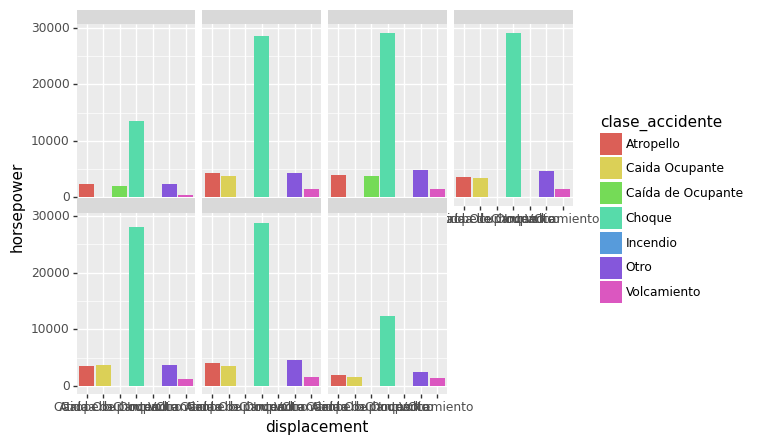

<ggplot: (8760284309645)>

In [ ]:


(
    p9.ggplot(df, p9.aes(x='clase_accidente', fill = 'clase_accidente'))
    + p9.geom_bar()
    + p9.facet_wrap('ano',
                 ncol = 4 # change the number of columns
                )
    + p9.labs(x='displacement', y='horsepower')
    + p9.theme(strip_text = p9.element_blank())
)



In [ ]:
#df.set_index("fecha_accidente", inplace=True)

In [ ]:
df.columns
df['fecha_accidente']=pd.to_datetime(df['fecha_accidente'], format='%d/%m/%Y %H:%M:%S')

In [ ]:
conteos = (
     df >>
     group_by(df.fecha_accidente , df.clase_accidente, df.barrio, df.comuna,df.location) >>
     summarise(y=n())
 )

[2022-11-21 03:01:27][datar][   INFO] `summarise()` has grouped output by ['fecha_accidente', 'clase_accidente', 'barrio', 'comuna'] (override with `_groups` argument)
INFO:datar:`summarise()` has grouped output by ['fecha_accidente', 'clase_accidente', 'barrio', 'comuna'] (override with `_groups` argument)


In [ ]:
conteos = pd.DataFrame(conteos)
type(conteos)

pandas.core.frame.DataFrame

In [ ]:
#conteos["fecha_accidente"] = conteos.fecha_accidente.dt.date


In [ ]:
conteos.head(5)

,fecha_accidente,clase_accidente,barrio,comuna,location,y
,<datetime64[ns]>,<object>,<object>,<object>,<object>,<int64>
0,2015-10-21 05:58:00,Caida Ocupante,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",1
1,2015-11-05 03:00:00,Choque,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",1
2,2015-10-21 07:40:00,Otro,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",1
3,2015-10-21 12:00:00,Atropello,Santo Domingo Savio No. 1,Popular,"[-75.5442195069, 6.30019383306]",1
4,2015-11-03 06:16:00,Choque,Santa Fé,Guayabal,"[-75.578180998, 6.21699243701]",1


In [ ]:

conteos["dia"] = conteos.fecha_accidente.dt.day
conteos["mes"] = conteos.fecha_accidente.dt.month
conteos["semana"] = conteos.fecha_accidente.dt.week
conteos["anio"] = conteos.fecha_accidente.dt.year


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
conteos["fecha"] = conteos.fecha_accidente.dt.date

In [ ]:
conteos.sort_values(by="anio") ## no funciona el sort, no se porque 
conteos['fecha']=pd.to_datetime(conteos['fecha'], format='%Y/%m/%d')
conteos[conteos["anio"] == 2014].head(5)

,fecha_accidente,clase_accidente,barrio,comuna,location,y,dia,mes,semana,anio,fecha
,<datetime64[ns]>,<object>,<object>,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<datetime64[ns]>
577,2014-09-27 05:30:00,Otro,Terminal de Transporte,Castilla,"[-75.5730009697, 6.27614313661]",1,27,9,39,2014,2014-09-27
578,2014-09-27 13:30:00,Choque,Caribe,Castilla,"[-75.573135644, 6.27398165897]",1,27,9,39,2014,2014-09-27
579,2014-09-27 19:20:00,Otro,Villa Nueva,La Candelaria,"[-75.563547107, 6.25544942344]",1,27,9,39,2014,2014-09-27
580,2014-09-27 12:00:00,Caída de Ocupante,San Bernardo,Belén,"[-75.5971182139, 6.22884823648]",1,27,9,39,2014,2014-09-27
581,2014-09-27 15:05:00,Choque,Florida Nueva,Laureles Estadio,"[-75.5923224714, 6.24960111841]",1,27,9,39,2014,2014-09-27


In [ ]:
conteos['dia_especial'] = np.where(conteos.loc[:,'fecha'].isin(holidays['holidays_fecha']),1,0)

In [ ]:
from ast import literal_eval
x = []
y = []
for i in conteos['location']:
     x.append(np.array(literal_eval(i))[0])

for i in conteos['location']:
     y.append(np.array(literal_eval(i))[1])


In [ ]:
x

[-75.5688011014,
 -75.5693883283,
 -75.5503911403,
 -75.5442195069,
 -75.578180998,
 -75.561118009,
 -75.5810144962,
 -75.5752597216,
 -75.5624178534,
 -75.5931430393,
 -75.5793699432,
 -75.5728091884,
 -75.5669098459,
 -75.5585471916,
 -75.5490924205,
 -75.5692972079,
 -75.5730009697,
 -75.5603314988,
 -75.5904642503,
 -75.5503893538,
 -75.6443850839,
 -75.576549829,
 -75.5727516327,
 -75.5657083123,
 -75.5798722464,
 -75.5737229687,
 -75.5967277363,
 -75.5667633903,
 -75.5750384965,
 -75.6129196887,
 -75.5670384127,
 -75.5618215986,
 -75.5550981063,
 -75.5695196642,
 -75.5958141981,
 -75.5823753832,
 -75.5994715078,
 -75.5753574206,
 -75.5357199187,
 -75.5919964321,
 -75.569629034,
 -75.5585985022,
 -75.5696995962,
 -75.5963306991,
 -75.5447646897,
 -75.6039753736,
 -75.584139913,
 -75.581770727,
 -75.5778261666,
 -75.5500079595,
 -75.5703296967,
 -75.59183445,
 -75.5733203488,
 -75.547435641,
 -75.5544890249,
 -75.5995855517,
 -75.5681263378,
 -75.5810119941,
 -75.5998681408,
 -75.5

In [ ]:
#pd.Series(x)
conteos['ubicacion_x'] = pd.Series(x)
conteos['ubicacion_y'] = pd.Series(y)


In [ ]:
import plotly.express as px
conteos_accidente = conteos[conteos['clase_accidente']=='Choque']
conteos_accidente = conteos_accidente[['fecha','clase_accidente']].value_counts()
conteos_accidente = pd.DataFrame(conteos_accidente).reset_index()
fdasfd = px.data.stocks()
conteos_accidente = conteos_accidente.sort_values(by='fecha',ascending=True)
def time_serie():
    #fig = go.Figure()
    #fig.add_trace(go.Scatter(x=conteos['fecha_accidente'],y=conteos['0']))
    #fig.show()
    fig = px.line(conteos_accidente.iloc[:100], x='fecha', y=0)
    fig.show()

time_serie()
fdasfd

,date,GOOG,AAPL,AMZN,FB,NFLX,MSFT
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,2018-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2018-01-08,1.018172,1.011943,1.061881,0.959968,1.053526,1.015988
2,2018-01-15,1.032008,1.019771,1.053240,0.970243,1.049860,1.020524
3,2018-01-22,1.066783,0.980057,1.140676,1.016858,1.307681,1.066561
...,...,...,...,...,...,...,...
4,2018-01-29,1.008773,0.917143,1.163374,1.018357,1.273537,1.040708
100,2019-12-02,1.216280,1.546914,1.425061,1.075997,1.463641,1.720717
101,2019-12-09,1.222821,1.572286,1.432660,1.038855,1.421496,1.752239
102,2019-12-16,1.224418,1.596800,1.453455,1.104094,1.604362,1.784896


Se crea una variable para convertir las fechas en int Se guarda el dataframe

In [ ]:
conteos.to_csv(drive_path + 'conteos.csv')

In [ ]:
mask = (conteos['fecha'] > '2015-10-21') & (conteos['fecha'] <= '2016-10-21')
data = conteos.loc[mask]


In [ ]:
# #### crear la varible holidays, que e cero donde es festivo y 1 donde no, o viceversa, comparar 

# mathc = []
# for i in holidays:
#     if i == 

## 2. Agrupamiento

Se va a realizar un nuevo dataframe que solo contenga variables numéricas para luego realizarle clusterización.

Las nuevas variables numéricas del nuevo dataframe son son:

- Número de heridos
- Número de solo daño en el choque
- Número de con muertos 
- Número de choques
- Número de atropellos


In [ ]:
#Número de heridos

x = df[['barrio','gravedad_accidente']].value_counts()


In [ ]:
x.index

MultiIndex([(           'La Candelaria',  'Solo daños'),
            (              'Campo Amor',  'Solo daños'),
            (            'Barrio Colón',  'Solo daños'),
            (        'Perpetuo Socorro',  'Solo daños'),
            (                  'Caribe', 'Con heridos'),
            (           'La Candelaria', 'Con heridos'),
            (              'Campo Amor', 'Con heridos'),
            (        'Perpetuo Socorro', 'Con heridos'),
            (                  'Caribe',  'Solo daños'),
            (      'Los Conquistadores',  'Solo daños'),
            ...
            (              'Moscú No.1',  'Solo daños'),
            (                    '1020',  'Solo daños'),
            (               'Santander', 'Con muertos'),
            (      'Campo Valdés No. 2', 'Con muertos'),
            (                    '1015',  'Solo daños'),
            ('Santo Domingo Savio No.1',  'Solo daños'),
            (              'Cristo Rey', 'Con muertos'),
            (  

In [ ]:
nuevo_df = pd.DataFrame(x)
nuevo_df = nuevo_df.reset_index()

In [ ]:
nuevo_df = nuevo_df.pivot(index='barrio', columns='gravedad_accidente', values=0).reset_index()
nuevo_df = nuevo_df.fillna(0)


In [ ]:
nuevo_df = nuevo_df[['barrio','Con muertos']]
nuevo_df

gravedad_accidente,barrio,Con muertos
,<object>,<float64>
0,0,3.0
1,0103,0.0
2,0105,0.0
3,0109,0.0
...,...,...
4,0202,0.0
423,Yolombo,0.0
424,Área de Expansión Altavista,0.0
425,Área de Expansión Altos de Calasanz,0.0


In [ ]:
x1 = df[['barrio','clase_accidente']].value_counts()
x1

barrio                      clase_accidente
La Candelaria               Choque             4120
Perpetuo Socorro            Choque             3978
Campo Amor                  Choque             3892
Caribe                      Choque             3593
Barrio Colón                Choque             3489
                                               ... 
Santa Elena Sector Central  Volcamiento           1
Trece de Noviembre          Caida Ocupante        1
Santa Elena Sector Central  Otro                  1
0914                        Choque                1
Suburbano El Plan           Volcamiento           1
Length: 2118, dtype: int64

In [ ]:
nuevo_df1 = pd.DataFrame(x1)
nuevo_df1 = nuevo_df1.reset_index()

In [ ]:
nuevo_df1 = nuevo_df1.pivot(index='barrio', columns='clase_accidente', values=0).reset_index()
nuevo_df1 = nuevo_df1.fillna(0)

In [ ]:
nuevo_df1 = nuevo_df1[['barrio','Atropello']]
nuevo_df1

clase_accidente,barrio,Atropello
,<object>,<float64>
0,0,66.0
1,0103,1.0
2,0105,2.0
3,0109,0.0
...,...,...
4,0202,0.0
423,Yolombo,1.0
424,Área de Expansión Altavista,2.0
425,Área de Expansión Altos de Calasanz,8.0


Diseño de vía

In [ ]:
diseño = df[['barrio','diseno']].value_counts()
df_diseño = pd.DataFrame(diseño)
df_diseño = diseño.reset_index()
df_diseño = df_diseño.pivot(index='barrio', columns='diseno', values=0).reset_index()
df_diseño = df_diseño.fillna(0)
df_diseño

diseno,barrio,Ciclo Ruta,Glorieta,Interseccion,Lote o Predio,Paso Elevado,Paso Inferior,Paso a Nivel,Pontón,Puente,Tramo de via,Tunel,Via peatonal
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,0,4.0,15.0,77.0,279.0,5.0,5.0,1.0,0.0,6.0,647.0,7.0,0.0
1,0103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2,0105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0109,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
423,Yolombo,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0
424,Área de Expansión Altavista,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
425,Área de Expansión Altos de Calasanz,0.0,0.0,4.0,23.0,0.0,0.0,0.0,0.0,0.0,85.0,0.0,0.0


In [ ]:
juntos = pd.merge(nuevo_df,nuevo_df1,how='inner',on="barrio")
juntos2 = pd.merge(juntos,df_diseño,how='inner',on="barrio")

In [ ]:
repetidos = [
  ['Asomadera No. 1', 'Asomadera No.1'],
  ['Aures No.2', 'Aures No. 2'],
  ['Aguas frias', 'Aguas Frias'],
  ['Berlin', 'Berlín'],
  ['Bomboná No. 1', 'Bomboná No.1'],
  ['Campo Valdés No.2', 'Campo Valdés No. 2'],
  ['Manrique Central No.1', 'Manrique Central No. 1'],
  ['Manrique Central No.2', 'Manrique Central No. 2'],
  ['Moscú No.2', 'Moscú No. 2'],
  ['Moscú No.1', 'Moscú No. 1'],
  ['Nueva Villa de La Iguaná', 'Nueva Villa de la Iguaná'],
  ['Santo Domingo Savio No.1', 'Santo Domingo Savio No. 1'],
  ['Versalles No.2', 'Versalles No. 2'],
  ['Versalles No.1', 'Versalles No. 1'],
  ['Villa Liliam', 'Villa Lilliam']
 ]

juntos3 = juntos2.copy()

for lista in repetidos:

  tin = juntos3[juntos3['barrio'].isin(lista)]
  tin = tin.sum()

  tin['barrio'] = lista[0]

  juntos3[juntos3['barrio'] == lista[0]] =  tin

  if len(lista) > 1:
    mask = ~juntos3['barrio'].isin(lista[1:])
    juntos3 = juntos3.loc[mask, :]


In [ ]:
codigo_barrio = pd.read_csv(drive_path + 'codigo_barrio.csv')
codigo_barrio['codigos'] = codigo_barrio['codigos'].apply(lambda x: str(x).zfill(4))

diccionario_barrio = dict(zip(codigo_barrio['codigos'], codigo_barrio['nombres']))


#df['barrio'] = df['barrio'].apply(lambda x:x.replace('\\xC1','Á'))
for word, replacement in diccionario_barrio.items():
  juntos3['barrio'] = juntos3['barrio'].apply(lambda x:x.replace(word,replacement))

In [ ]:
import unidecode 

juntos3['barrio junto'] = juntos3['barrio']
juntos3['barrio junto'] = juntos3['barrio junto'].str.replace(' ','')
juntos3['barrio junto'] = juntos3['barrio junto'].str.replace('No.|N°','')
juntos3['barrio junto'] = juntos3['barrio junto'].str.replace('-','')
juntos3['barrio junto'] = juntos3['barrio junto'].str.lower()
juntos3[['barrio junto']] = juntos3[['barrio junto']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
juntos3.sort_values(['barrio junto'], inplace=True)
juntos3.reset_index(inplace=True, drop=True)

In [ ]:
agrup = {
  'barrio': max,
  'Con muertos': sum,
  'Atropello': sum,
  'Ciclo Ruta': sum,
  'Glorieta': sum,
  'Interseccion': sum,
  'Lote o Predio': sum,
  'Paso Elevado': sum,
  'Paso Inferior': sum,
  'Paso a Nivel': sum,
  'Pontón': sum,
  'Puente': sum,
  'Tramo de via': sum,
  'Tunel': sum,
  'Via peatonal': sum
}
juntos2 = juntos3.groupby('barrio junto').agg(agrup).reset_index(drop=True)

<function matplotlib.pyplot.show(*args, **kw)>

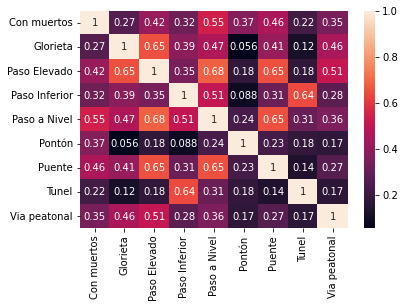

In [ ]:
corrMatrix=juntos2.drop(['Atropello','Ciclo Ruta','Interseccion','Lote o Predio','Tramo de via'],axis=1).corr()
sb.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (20,20)
plt.show

In [ ]:
m = ~(corrMatrix.mask(np.eye(len(corrMatrix), dtype=bool)).abs() > 0.7).any()
raw = corrMatrix.loc[m, m]
raw

,Con muertos,Glorieta,Paso Elevado,Paso Inferior,Paso a Nivel,Pontón,Puente,Tunel,Via peatonal
,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
Con muertos,1.000000,0.267119,0.415289,0.317795,0.545562,0.373167,0.460533,0.223138,0.345853
Glorieta,0.267119,1.000000,0.654919,0.390797,0.466292,0.055802,0.410795,0.117264,0.457020
Paso Elevado,0.415289,0.654919,1.000000,0.345626,0.684484,0.179813,0.653920,0.178293,0.513795
Paso Inferior,0.317795,0.390797,0.345626,1.000000,0.508856,0.088271,0.314334,0.643410,0.284231
Paso a Nivel,0.545562,0.466292,0.684484,0.508856,1.000000,0.236047,0.654498,0.313673,0.355007
Pontón,0.373167,0.055802,0.179813,0.088271,0.236047,1.000000,0.228372,0.183910,0.172202
Puente,0.460533,0.410795,0.653920,0.314334,0.654498,0.228372,1.000000,0.135162,0.266087
Tunel,0.223138,0.117264,0.178293,0.643410,0.313673,0.183910,0.135162,1.000000,0.167003
Via peatonal,0.345853,0.457020,0.513795,0.284231,0.355007,0.172202,0.266087,0.167003,1.000000


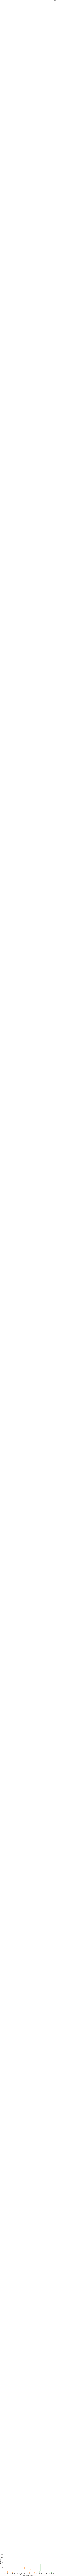

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot

pyplot.figure(figsize=(15, 7))  
pyplot.title("Dendrograma") 
dend = shc.dendrogram(shc.linkage(juntos2.drop(['Atropello','Ciclo Ruta','Interseccion','Lote o Predio','Tramo de via','barrio'],axis=1), method='ward'),truncate_mode="lastp")# Dendrograma usando ward como método de linkage.
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [200000, 200000], '--', c='k')
ax.text(bounds[1], 200000, ' Seis grupos', va='center', fontdict={'size': 15})
plt.xlabel("Cantidad de samples <(n)>, índice <i>")
plt.ylabel("Distancias de grupos")
plt.show()

Valores:  [1942739.7970149275, 494981.64923076914, 288050.79923076945, 156223.841503268, 131137.66984659625, 110098.4864548497, 86092.00263453505, 71831.45542237438, 61024.508993802956, 52041.44626198604, 45442.71150793649, 38777.89484126984, 32647.031766917287, 27355.844841269827, 23813.53954252864]


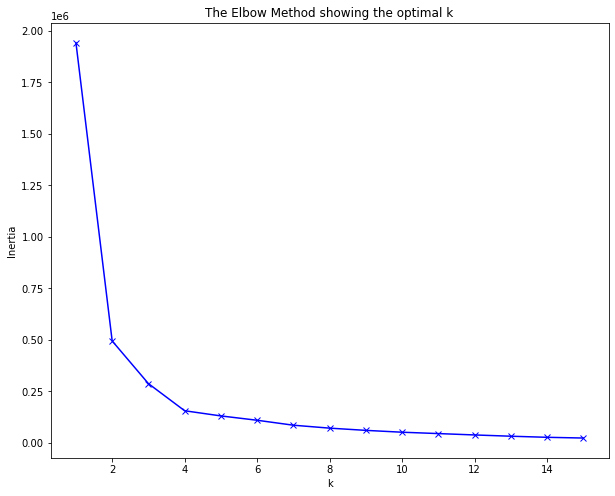

In [ ]:
from sklearn.cluster import KMeans
def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)
  
# Grafico de los resultados obtenidos para cada valor del rango
  print("Valores: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

elbow_curve(np.array(juntos2.drop(['Atropello','Ciclo Ruta','Interseccion','Lote o Predio','Tramo de via','barrio'],axis=1)))

For n_clusters = 2 The average silhouette_score is : 0.9325611408473762
For n_clusters = 3 The average silhouette_score is : 0.9245269795617455
For n_clusters = 4 The average silhouette_score is : 0.847810882248146
For n_clusters = 5 The average silhouette_score is : 0.8087925521015448
For n_clusters = 6 The average silhouette_score is : 0.8043401390504525
For n_clusters = 7 The average silhouette_score is : 0.8205347063687982
For n_clusters = 8 The average silhouette_score is : 0.8273985948151453
For n_clusters = 9 The average silhouette_score is : 0.82333891418708
For n_clusters = 10 The average silhouette_score is : 0.80971183799454
For n_clusters = 11 The average silhouette_score is : 0.8108863696863942
For n_clusters = 12 The average silhouette_score is : 0.770322226412939
For n_clusters = 13 The average silhouette_score is : 0.7532280835711104
For n_clusters = 14 The average silhouette_score is : 0.766326735548553


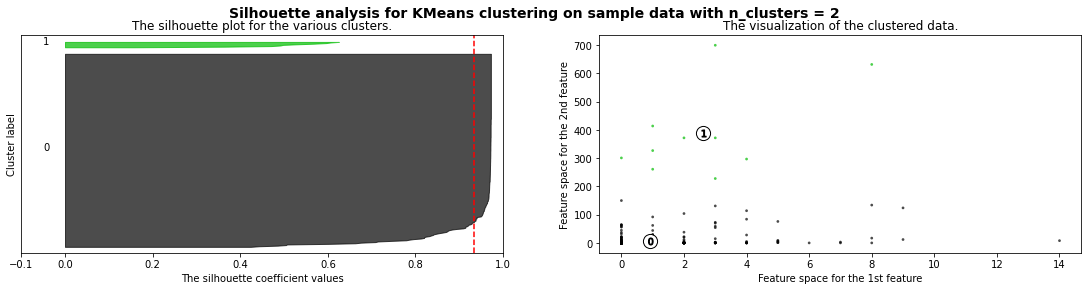

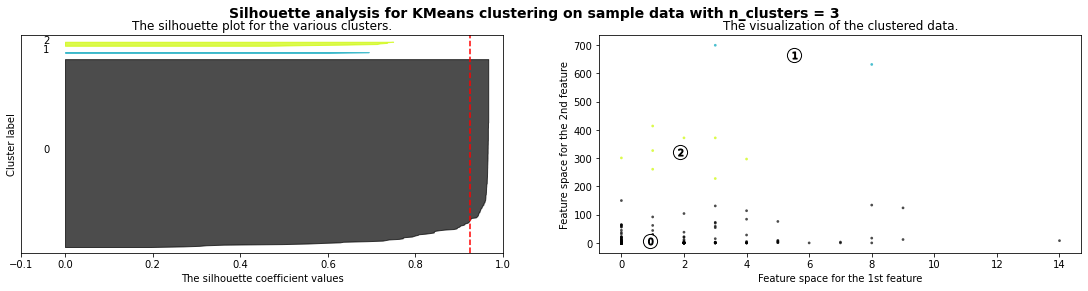

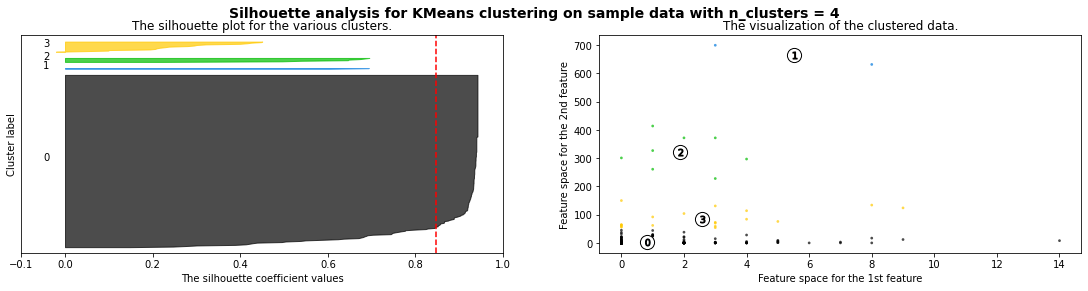

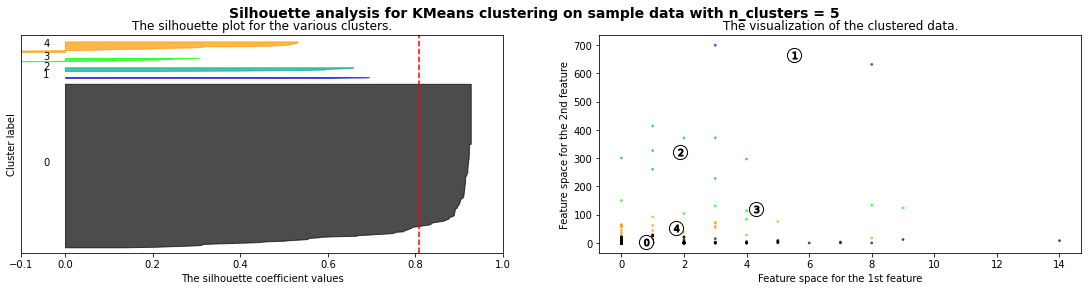

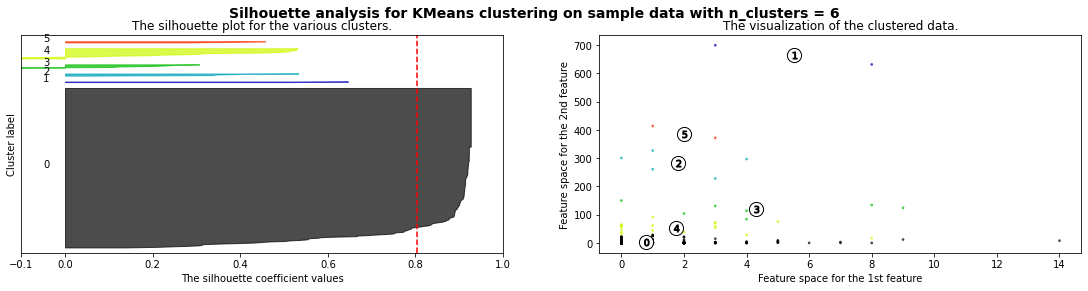

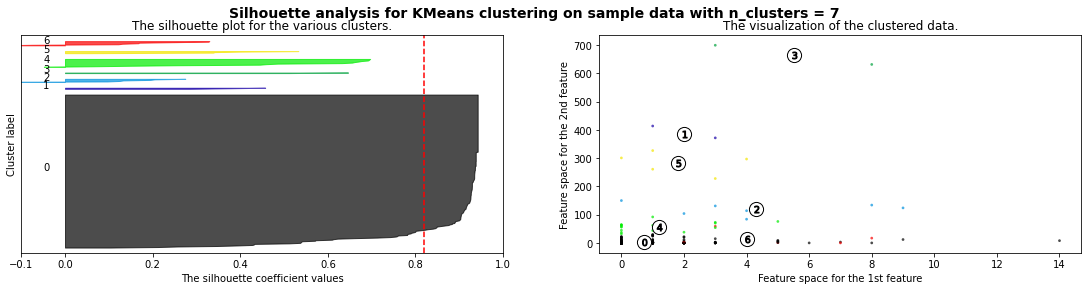

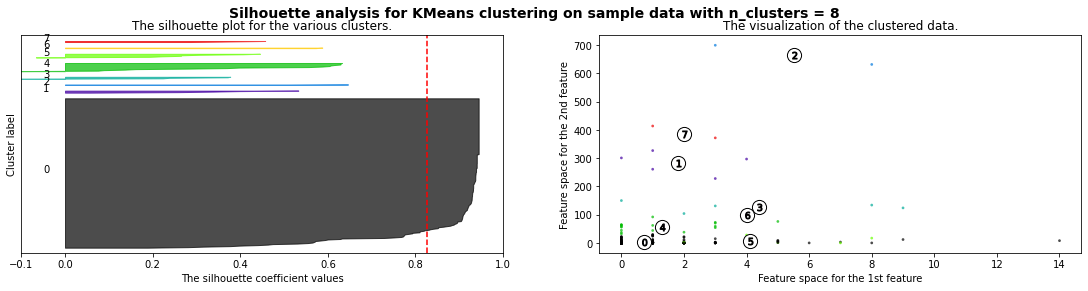

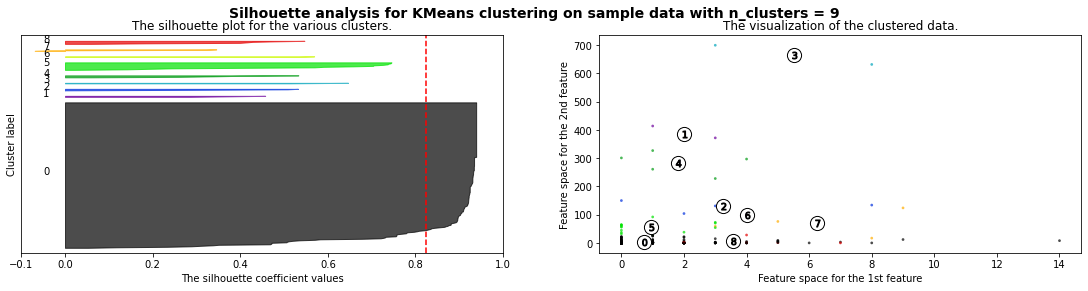

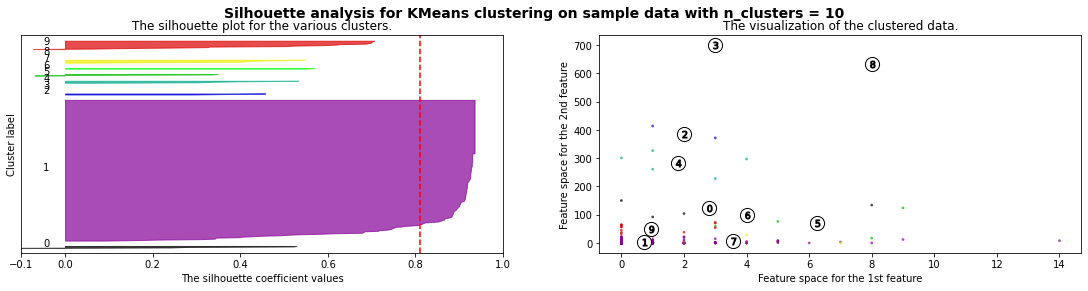

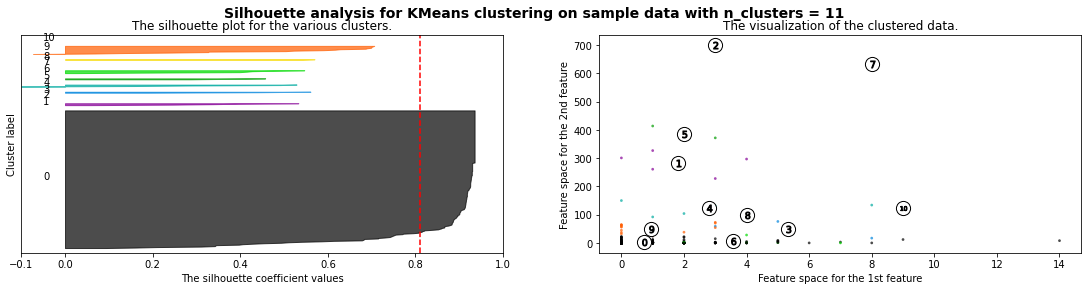

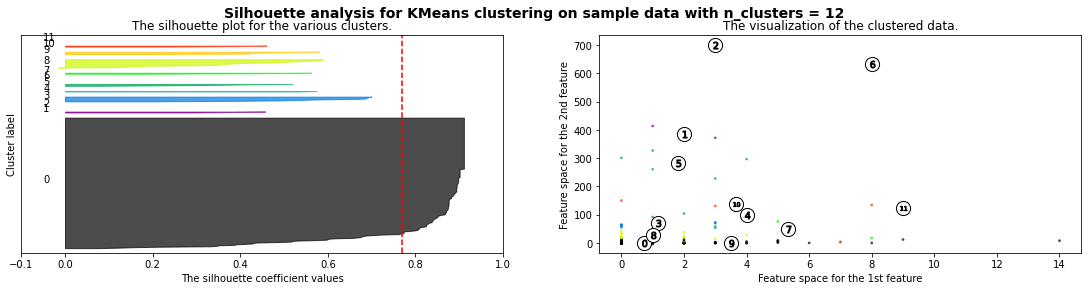

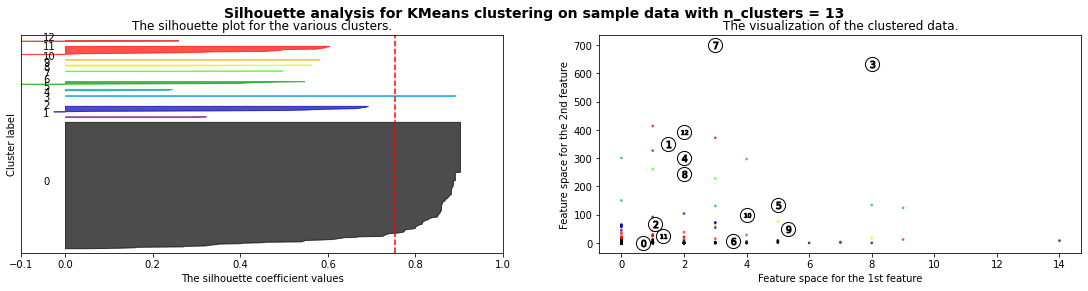

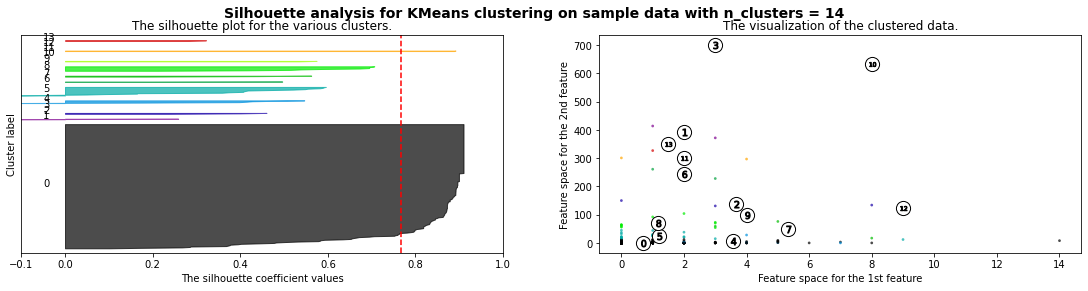

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

colors_k_means = ['cyan','purple','orange']
range_n_clusters = list(range(2,15))
X = np.array(juntos2.drop(['Atropello','Ciclo Ruta','Interseccion','Lote o Predio','Tramo de via','barrio'],axis=1))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Modelo

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering= AgglomerativeClustering(n_clusters=4,linkage="ward")
clustering.fit(juntos2.drop(['Atropello','Ciclo Ruta','Interseccion','Lote o Predio','Tramo de via','barrio'],axis=1))
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
final=juntos2
final["cluster"]=clustering.labels_

pd.set_option('max_rows',99999)

final

,barrio,Con muertos,Atropello,Ciclo Ruta,Glorieta,Interseccion,Lote o Predio,Paso Elevado,Paso Inferior,Paso a Nivel,Pontón,Puente,Tramo de via,Tunel,Via peatonal,cluster
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<int64>
0,0,3.0,66.0,4.0,15.0,77.0,279.0,5.0,5.0,1.0,0.0,6.0,647.0,7.0,0.0,0
1,5002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0
2,6001,0.0,1.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0
3,7001,0.0,10.0,0.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0
4,7002,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0
5,9004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0
6,9086,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
7,Aguas frias,0.0,18.0,0.0,0.0,2.0,13.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0,0
8,Aldea Pablo VI,0.0,24.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0


Se dropean las primeras 7 filas ya que son numeros y no les encontramos equivalencia en código de barrio (esto es un triple porque igualmente lo vamos a dropear pero no encuentro justificación)

In [ ]:
final = final.iloc[7:].reset_index()
final.drop(['index'], axis=1, inplace=True)
final

,barrio,Con muertos,Atropello,Ciclo Ruta,Glorieta,Interseccion,Lote o Predio,Paso Elevado,Paso Inferior,Paso a Nivel,Pontón,Puente,Tramo de via,Tunel,Via peatonal,cluster
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<int64>
0,Aguas frias,0.0,18.0,0.0,0.0,2.0,13.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0,0
1,Aldea Pablo VI,0.0,24.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0
2,Alejandría,0.0,18.0,1.0,4.0,96.0,88.0,0.0,0.0,1.0,0.0,1.0,440.0,0.0,0.0,0
3,Alejandro Echavarría,2.0,108.0,3.0,20.0,193.0,148.0,0.0,1.0,0.0,0.0,0.0,667.0,0.0,0.0,0
4,Alfonso López,0.0,149.0,9.0,0.0,161.0,158.0,0.0,0.0,1.0,0.0,0.0,835.0,0.0,0.0,0
5,Altamira,0.0,49.0,9.0,11.0,99.0,117.0,0.0,0.0,0.0,0.0,0.0,541.0,0.0,0.0,0
6,Altavista,0.0,62.0,2.0,0.0,63.0,40.0,0.0,0.0,0.0,0.0,0.0,266.0,0.0,0.0,0
7,Altavista Sector Central,0.0,39.0,2.0,0.0,14.0,27.0,0.0,0.0,0.0,0.0,0.0,172.0,0.0,0.0,0
8,Altos del Poblado,1.0,16.0,1.0,1.0,39.0,34.0,2.0,0.0,0.0,0.0,0.0,247.0,0.0,0.0,0


In [ ]:
final.to_csv('/content/gdrive/Shareddrives/TAE/trabajo3/datos/df_final_con_clusters.csv', index=False)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_3d(final, x="Glorieta", y="Paso Elevado", z="Con muertos",color="cluster",size_max=0.0001)
fig.show()

# Sin dropear


<function matplotlib.pyplot.show(*args, **kw)>

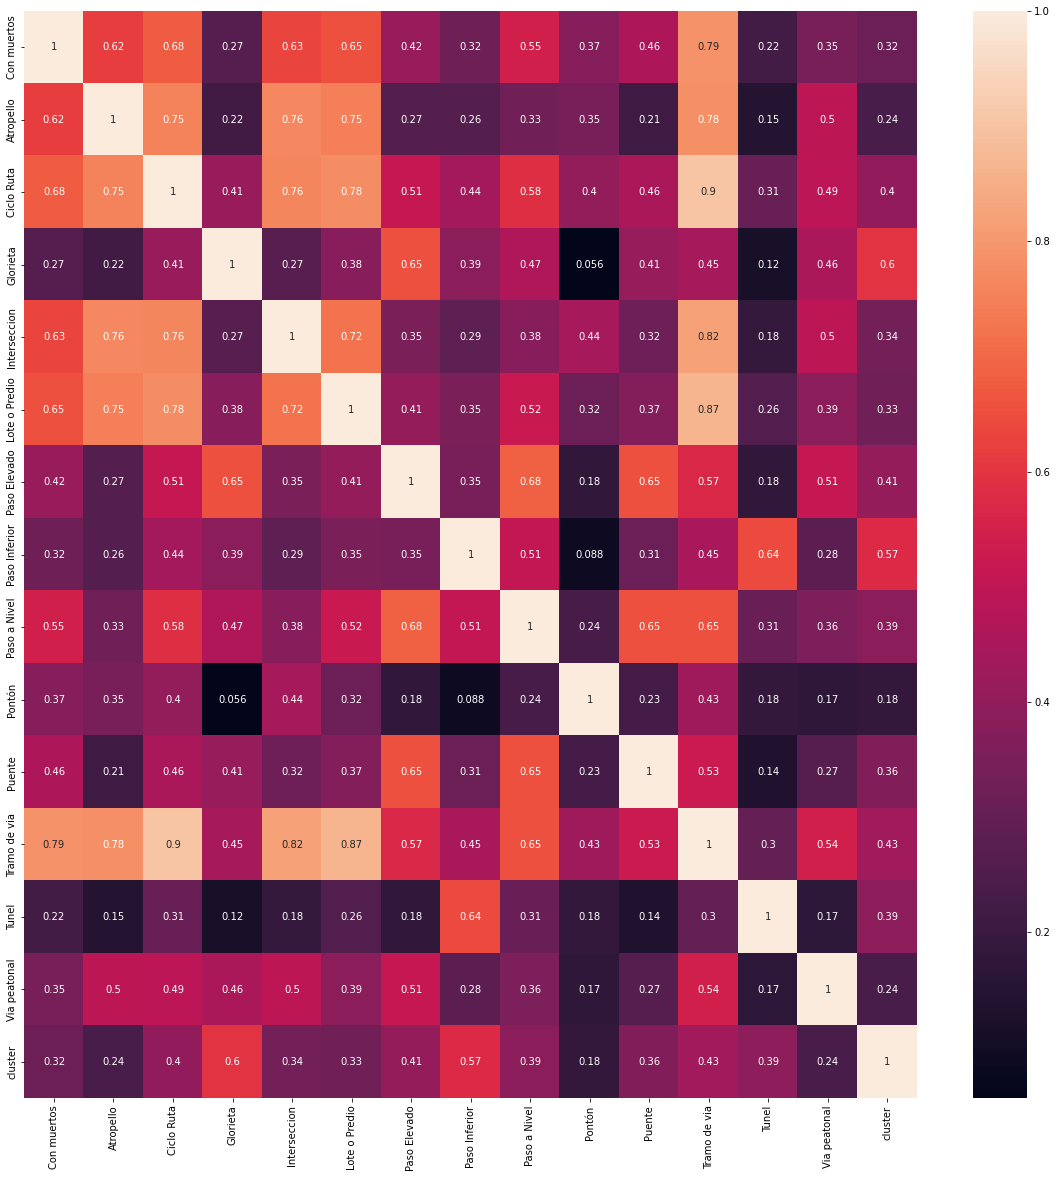

In [ ]:
corrMatrix=juntos2.drop(['barrio'],axis=1).corr()
sb.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (20,20)
plt.show

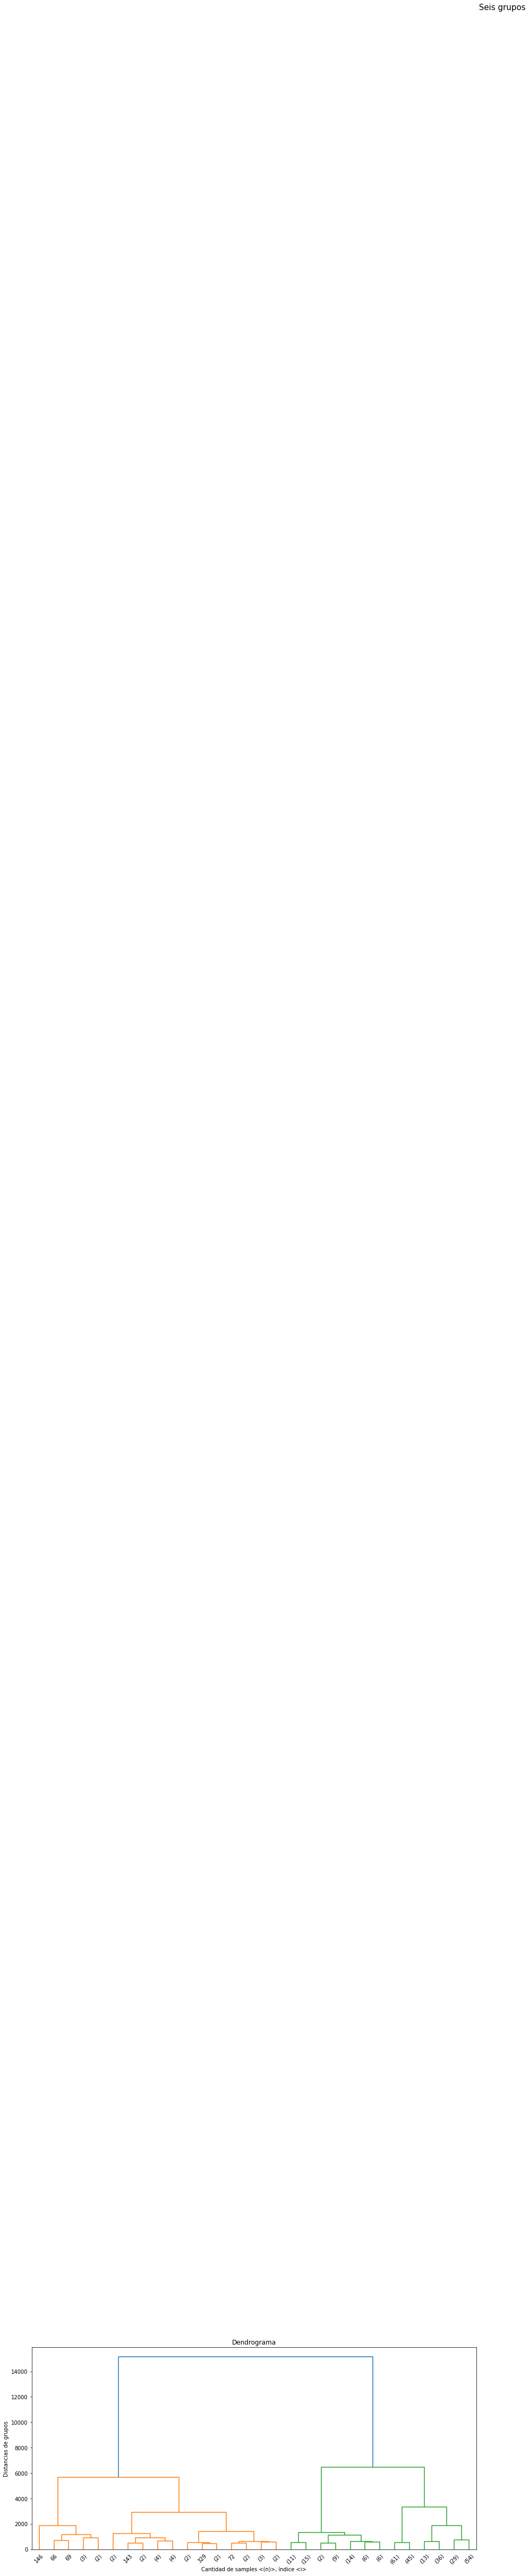

In [ ]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot

pyplot.figure(figsize=(15, 7))  
pyplot.title("Dendrograma") 
dend = shc.dendrogram(shc.linkage(juntos2.drop(['barrio'],axis=1), method='ward'),truncate_mode="lastp")# Dendrograma usando ward como método de linkage.
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [200000, 200000], '--', c='k')
ax.text(bounds[1], 200000, ' Seis grupos', va='center', fontdict={'size': 15})
plt.xlabel("Cantidad de samples <(n)>, índice <i>")
plt.ylabel("Distancias de grupos")
plt.show()

Valores:  [174118540.7104478, 59166456.05528054, 30299882.089429565, 20257369.63581619, 15475159.357103974, 12149209.042318808, 10438922.510483172, 9225960.542638406, 8331695.526254832, 7314138.077476241, 6486251.385674212, 5916991.744762249, 5233065.060275087, 4822554.293674444, 4769829.758723953]


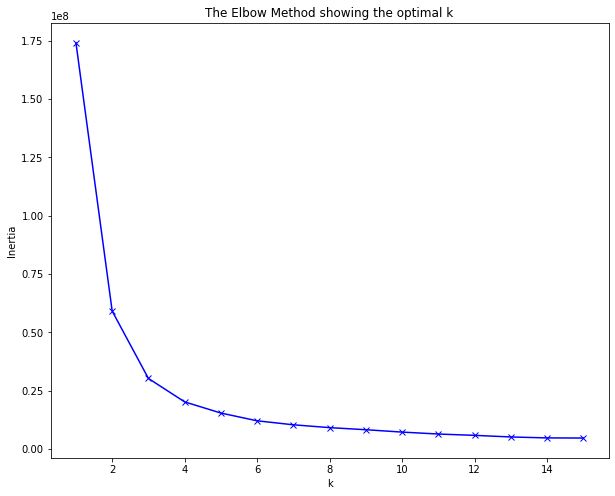

In [ ]:
from sklearn.cluster import KMeans
def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)
  
# Grafico de los resultados obtenidos para cada valor del rango
  print("Valores: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

elbow_curve(np.array(juntos2.drop(['barrio'],axis=1)))

For n_clusters = 2 The average silhouette_score is : 0.7589904115451855
For n_clusters = 3 The average silhouette_score is : 0.6114223931903872
For n_clusters = 4 The average silhouette_score is : 0.5753617807945761
For n_clusters = 5 The average silhouette_score is : 0.5249397213823284
For n_clusters = 6 The average silhouette_score is : 0.5240830940969282
For n_clusters = 7 The average silhouette_score is : 0.5224713873829182
For n_clusters = 8 The average silhouette_score is : 0.48427102681398604
For n_clusters = 9 The average silhouette_score is : 0.47597855638846714
For n_clusters = 10 The average silhouette_score is : 0.4694043547177815
For n_clusters = 11 The average silhouette_score is : 0.471781693431123
For n_clusters = 12 The average silhouette_score is : 0.4728946969911046
For n_clusters = 13 The average silhouette_score is : 0.482304730094261
For n_clusters = 14 The average silhouette_score is : 0.4853034320913346


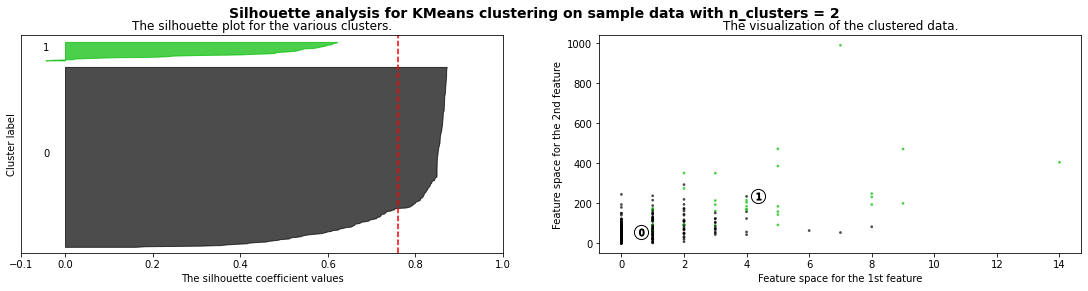

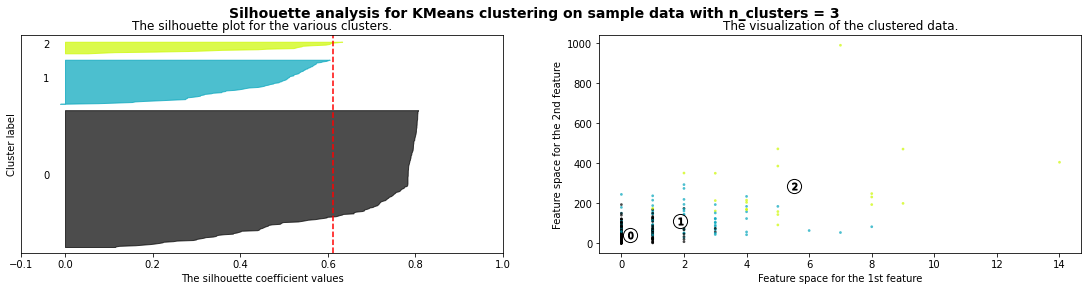

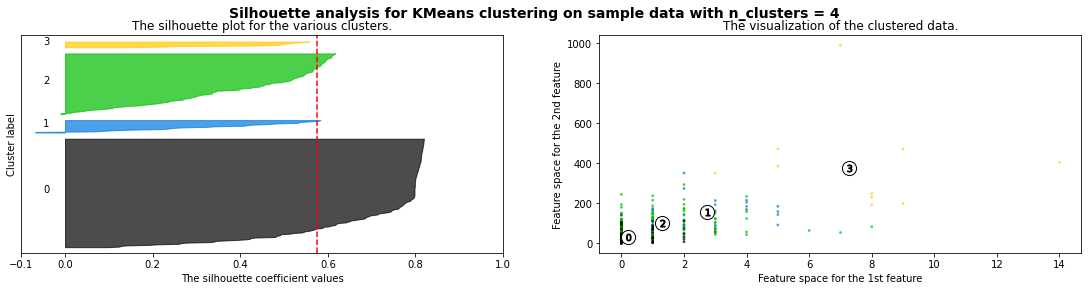

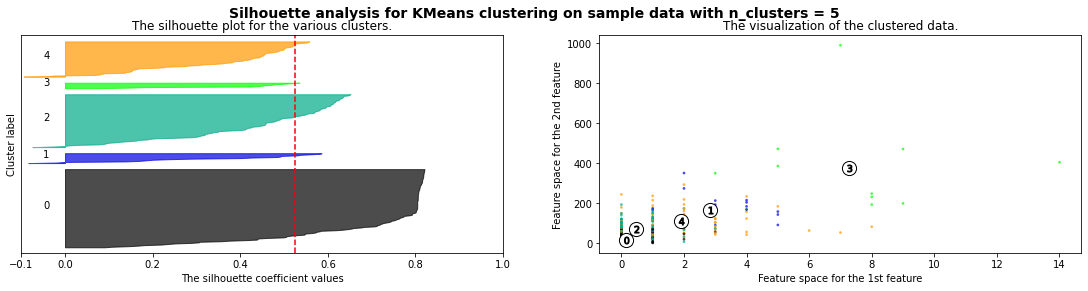

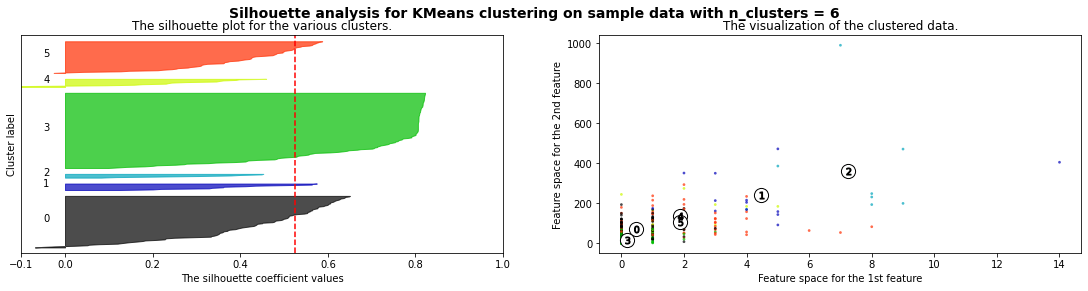

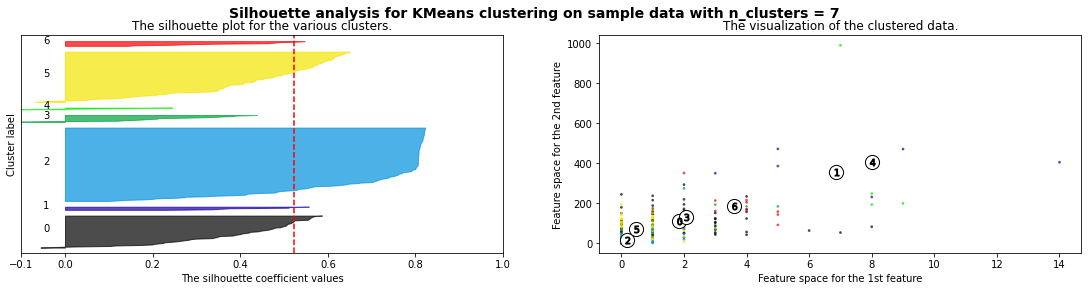

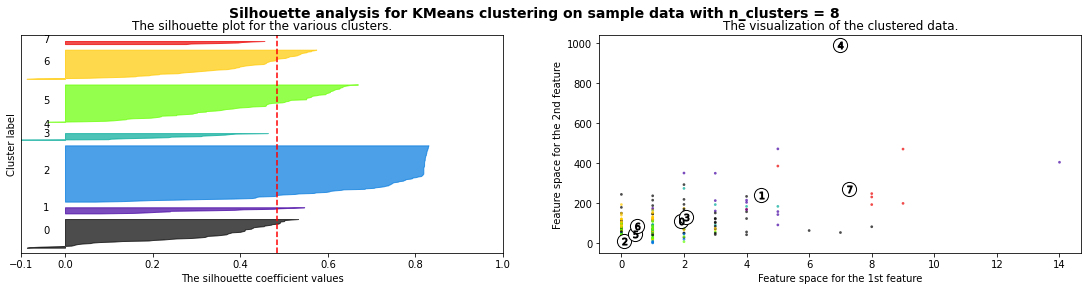

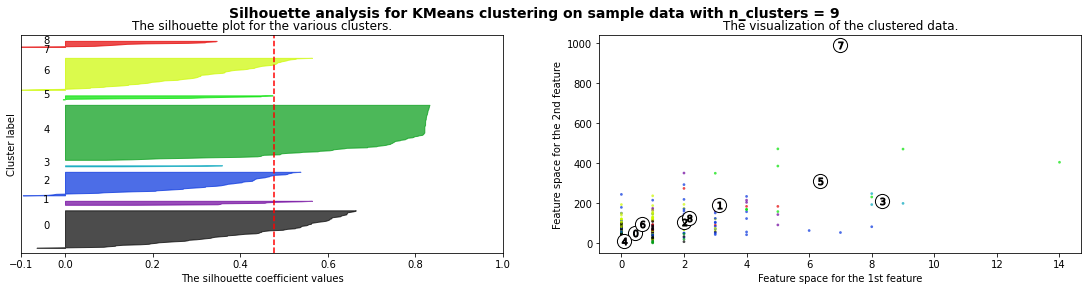

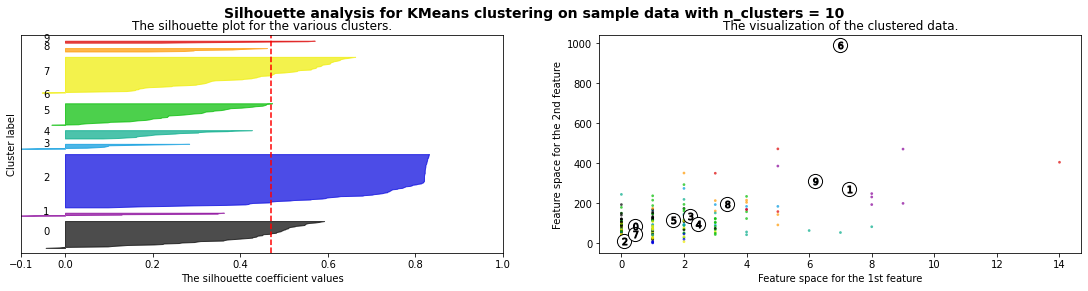

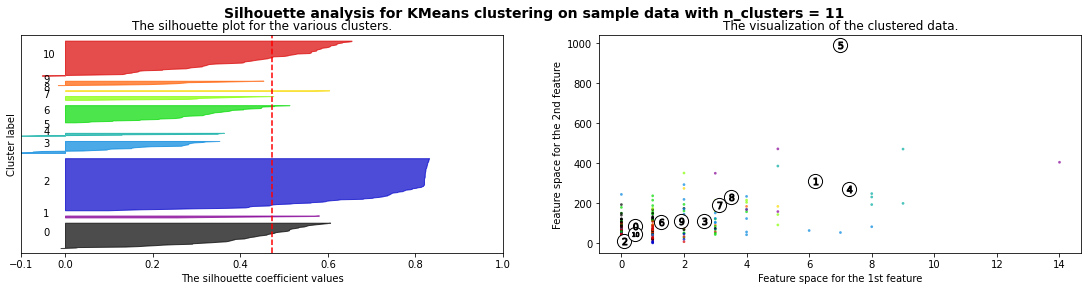

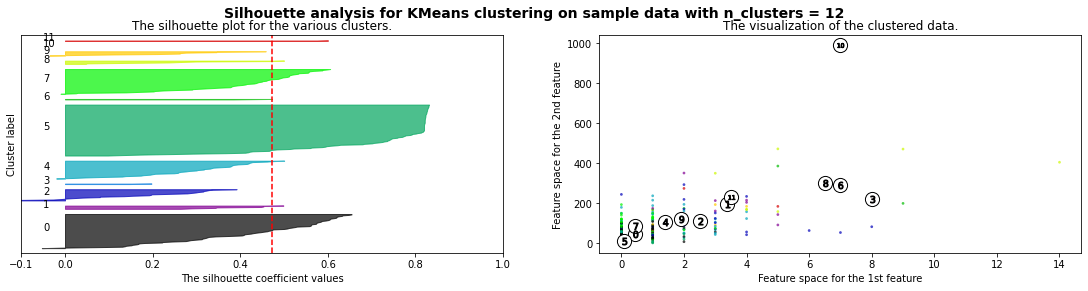

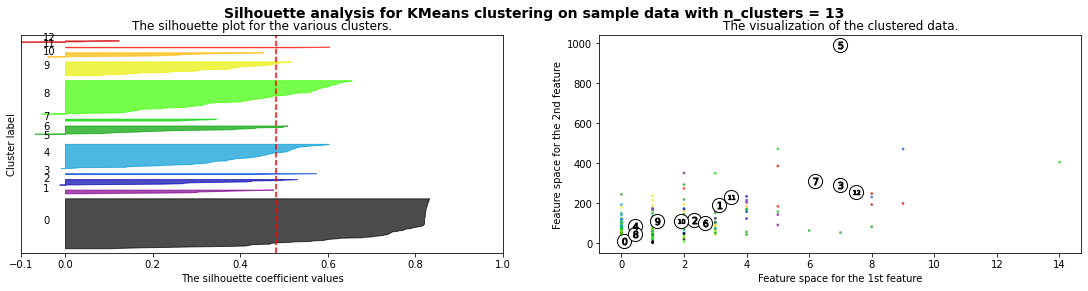

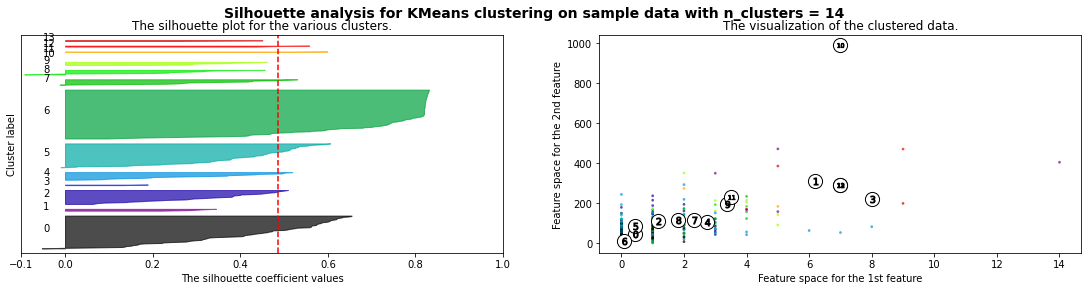

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

colors_k_means = ['cyan','purple','orange']
range_n_clusters = list(range(2,15))
X = np.array(juntos2.drop(['barrio'],axis=1))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering= AgglomerativeClustering(n_clusters=6,linkage="ward")
clustering.fit(juntos2.drop(['barrio'],axis=1))
clustering.labels_

array([2, 4, 4, 4, 4, 4, 4, 4, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4,
       2, 4, 2, 0, 4, 0, 4, 4, 0, 0, 0, 2, 2, 1, 4, 0, 4, 4, 2, 3, 0, 0,
       2, 0, 4, 4, 0, 4, 2, 0, 4, 0, 5, 0, 0, 2, 4, 1, 0, 4, 0, 0, 5, 0,
       1, 2, 2, 1, 3, 4, 3, 2, 0, 0, 0, 2, 3, 0, 5, 2, 2, 0, 0, 0, 4, 0,
       4, 0, 5, 0, 4, 4, 0, 2, 0, 2, 4, 0, 4, 0, 4, 5, 0, 5, 4, 0, 2, 0,
       0, 0, 4, 0, 4, 4, 0, 4, 0, 2, 2, 4, 2, 0, 0, 2, 0, 4, 0, 2, 0, 0,
       3, 3, 2, 4, 0, 0, 5, 4, 0, 2, 5, 5, 2, 0, 1, 0, 0, 4, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 2, 4, 4, 0, 0, 0, 0, 0, 0, 2, 4, 4, 0, 2, 2, 2, 0, 0, 2,
       0, 2, 0, 3, 1, 0, 0, 2, 5, 2, 0, 2, 4, 4, 4, 4, 0, 2, 4, 4, 2, 0,
       0, 3, 0, 0, 4, 4, 0, 2, 4, 4, 4, 0, 0, 4, 2, 0, 2, 2, 4, 4, 1, 4,
       2, 4, 4, 4, 0, 4, 0, 4, 5, 2, 2, 4, 3, 2, 3, 2, 2, 0, 0, 0, 4, 4,
       4, 4, 0, 0, 0, 0, 2, 0, 4, 1, 0, 0, 0, 2, 0, 0, 4, 0, 0, 4, 2, 0,
       4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4,

In [ ]:
final=juntos2
final["cluster"]=clustering.labels_

final

,barrio,Con muertos,Atropello,Ciclo Ruta,Glorieta,Interseccion,Lote o Predio,Paso Elevado,Paso Inferior,Paso a Nivel,Pontón,Puente,Tramo de via,Tunel,Via peatonal,cluster
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<int64>
0,0,3.0,66.0,4.0,15.0,77.0,279.0,5.0,5.0,1.0,0.0,6.0,647.0,7.0,0.0,2
1,5002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4
2,6001,0.0,1.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,4
3,7001,0.0,10.0,0.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,4
4,7002,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4
5,9004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4
6,9086,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
7,Aguas frias,0.0,18.0,0.0,0.0,2.0,13.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,0.0,4
8,Aldea Pablo VI,0.0,24.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,4


In [ ]:
final.to_csv(drive_path + 'final.csv')

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_3d(final, x="Glorieta", y="Con muertos", z="Paso Elevado",color="cluster",labels='barrio',size_max=0.0001)
fig.show()

In [ ]:
final[final["cluster"] == 1]['Glorieta'].mean()

135.25

In [ ]:
final[final["cluster"] == 2]['Glorieta'].mean()

20.142857142857142

In [ ]:
final[final["cluster"] == 3]['Glorieta'].mean()

109.3076923076923

In [ ]:
final[final["cluster"] == 0]['Glorieta'].mean()

4.143939393939394

In [ ]:
pd.set_option('display.max_rows', None)